This is the second part in a series of notes on my exploration of the recently released [Google QuickDraw dataset](https://quickdraw.withgoogle.com/data), using the concurrently released [SketchRNN model][Ha2017]. 

In the [previous note](../exploring-the-google-quickdraw-dataset-with-sketchrnn-part-1/), we set up our development environment, downloaded a subset of the data along with some pre-trained models, and developed some utilities for visualizing the data in the notebook. We retain most of the code from previous note and omit the expository code and markdown cells.

---

The QuickDraw dataset is curated from the millions of drawings contributed by over 15 million people around the world who participated in the ["Quick, Draw!" A.I. Experiment](https://aiexperiments.withgoogle.com/quick-draw), in which they were given the challenge of drawing objects belonging to a particular class (such as "cat") in under 20 seconds.

SketchRNN is a very impressive generative model that was trained to produce vector drawings using this dataset. It was of particular interest to me because it cleverly combines many of the latest tools and techniques recently developed in machine learning, such as [Variational Autoencoders][Kingma2013], HyperLSTMs (a [HyperNetwork][Ha2016] for LSTM), [Autoregressive models][Reed2017], [Layer Normalization][Ba2016], [Recurrent Dropout][Semeniuta2016], the [Adam optimizer][Kingma2014], and others.

[Ha2017]: http://arxiv.org/abs/1704.03477 "D. Ha and D. Eck, 'A Neural Representation of Sketch Drawings,' Apr. 2017."
[Ha2016]: https://arxiv.org/abs/1609.09106 "D. Ha, A. Dai, and Q. V. Le, 'HyperNetworks,' Sep. 2016."
[Kingma2013]: https://arxiv.org/abs/1312.6114 "D. P. Kingma and M. Welling, 'Auto-Encoding Variational Bayes,' Dec. 2013."
[Reed2017]: https://arxiv.org/abs/1703.03664 "S. Reed et al., 'Parallel Multiscale Autoregressive Density Estimation,' Mar. 2017."
[Semeniuta2016]: https://arxiv.org/abs/1603.05118 "S. Semeniuta, A. Severyn, and E. Barth, 'Recurrent Dropout without Memory Loss,' Mar. 2016."
[Ba2016]: https://arxiv.org/abs/1607.06450 "J. L. Ba, J. R. Kiros, and G. E. Hinton, 'Layer Normalization,' Jul. 2016."
[Kingma2014]: https://arxiv.org/abs/1412.6980 "D. P. Kingma and J. Ba, 'Adam: A Method for Stochastic Optimization,' Dec. 2014."

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf

from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib import rc

from six.moves import map

In [50]:
from magenta.models.sketch_rnn.sketch_rnn_train import \
    (load_env,
     load_checkpoint,
     reset_graph,
     download_pretrained_models,
     PRETRAINED_MODELS_URL)
from magenta.models.sketch_rnn.model import Model, sample
from magenta.models.sketch_rnn.utils import (lerp,
                                             slerp,
                                             get_bounds, 
                                             to_big_strokes,
                                             to_normal_strokes)

In [52]:
# For inine display of animation
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [53]:
# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

In [54]:
tf.logging.info("TensorFlow Version: {}".format(tf.__version__))

INFO:tensorflow:TensorFlow Version: 1.1.0


### Getting the Pre-Trained Models and Data

In [7]:
DATA_DIR = ('http://github.com/hardmaru/sketch-rnn-datasets/'
            'raw/master/aaron_sheep/')
MODELS_ROOT_DIR = '/tmp/sketch_rnn/models'

In [8]:
DATA_DIR

'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'

In [9]:
PRETRAINED_MODELS_URL

'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'

In [10]:
download_pretrained_models(
    models_root_dir=MODELS_ROOT_DIR,
    pretrained_models_url=PRETRAINED_MODELS_URL)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


We look at the layer normalized model trained on the `aaron_sheep` dataset for now.

In [11]:
MODEL_DIR = MODELS_ROOT_DIR + '/aaron_sheep/layer_norm'

In [12]:
(train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model) = load_env(DATA_DIR, MODEL_DIR)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [222]:
class SketchPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)
        codes[0] = Path.MOVETO

        super(SketchPath, self).__init__(vertices, 
                                         codes, 
                                         *args, 
                                         **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd

In [69]:
def draw(sketch_data, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=sketch_data,
                                            factor=factor)

    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    sketch = SketchPath(sketch_data)

    patch = patches.PathPatch(sketch, facecolor='none')
    ax.add_patch(patch)

### The real fun begins

Everything up to here has more or less been copied straight from the previous notebook. Now we load the pre-trained SketchRNN model and use it to begin our exploration of the test dataset.

In [110]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [111]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [112]:
# loads the weights from checkpoint into our model
load_checkpoint(sess=sess, checkpoint_path=MODEL_DIR)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


The helper functions for encoding a sketch to some latent code $z$ and then decoding it back to a sketch were provided in the [original notebook](https://github.com/tensorflow/magenta/blob/9ed2479678a81b5a016d39c6024d10aa6be05e1f/magenta/models/sketch_rnn/sketch_rnn.ipynb). I just made some minor syntactic changes and removed the behaviour of plotting as a side-effect.

In [73]:
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    z = sess.run(eval_model.batch_z,
                 feed_dict={
                    eval_model.input_data: [strokes], 
                    eval_model.sequence_lengths: seq_len})[0]
    return z

In [74]:
def decode(z_input=None, temperature=.1, factor=.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(
        sess, 
        sample_model, 
        seq_len=eval_model.hps.max_seq_len, 
        temperature=temperature, z=z)
    return to_normal_strokes(sample_strokes)

Now we get a random sample from the test dataset

In [120]:
sketch = test_set.random_sample()

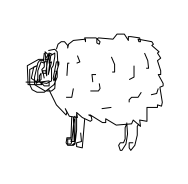

In [138]:
fig, ax = plt.subplots(figsize=(3, 3),
                       subplot_kw=dict(xticks=[], 
                                       yticks=[], 
                                       frame_on=False))

draw(sketch, ax=ax)

plt.show()

We project it into the 128-dimensional latent space using the pre-trained encoder

In [183]:
z = encode(sketch)
z.shape

(128,)

Now we can reconstruct the original sketch from the learned latent representation using the pre-trained decoder, with temperature $\tau=0.8$. The temperature parameter controls the level of randomness in the samples generated by the model, which becomes deterministic as $\tau \to 0$, and produces samples that are the most likely point in the probability density function. See pg. 7 of the [original paper](https://arxiv.org/abs/1704.03477) for further discussion of the effects the temperature parameter has on the sampling process.

In [216]:
sketch_reconstructed = decode(z, temperature=.6)
sketch_reconstructed.shape

(250, 3)

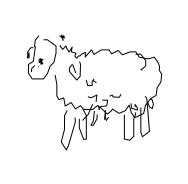

In [217]:
fig, ax = plt.subplots(figsize=(3, 3),
                       subplot_kw=dict(xticks=[], 
                                       yticks=[], 
                                       frame_on=False))

draw(sketch_reconstructed, ax=ax)

plt.show()

### Variance in the Reconstruction

The grid of drawings below consists of samples of the reconstructed drawings at various settings of the temperature parameter. The first column is the original drawing, and each of the remaining columns are 5 samples of the reconstructed drawing with $\tau$ increasing from 0.1 to 0.9.

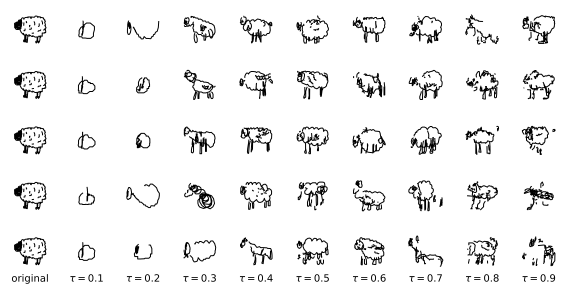

In [182]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        if not col_num:
            draw(sketch, ax=ax)
            xlabel = 'original'
        else:
            t = col_num / 10.
            draw(decode(z, temperature=t), ax=ax)
            xlabel = r'$\tau={}$'.format(t)
        if row_num+1 == len(ax_arr):
            ax.set_xlabel(xlabel)

plt.show()

At the lowest setting of the temperature at $\tau=0.1$, we see the samples consistently share a similar appearance - they all look like vertical strokes emanating from a fluffy cloud. However, they are also consistently dissimilar to the original sketch. In this sense, the samples from the models seems to exhibit high bias and low variance. As we increase the variance in the samples by increasing $\tau$, we start to find some samples that resemble our original sketch. But when we increase $\tau$ a little too much, beyond say 0.8, we begin to see a little too much randomness in the samples.

### Drawing Comparisons

Humans typically write and, by extension, draw from left to right, top to bottom. Here, I wanted to animate the process of the original sketch being drawn alongside the decoder's reconstruction of the sketch to compare stroke patterns, typical stroke lengths, etc.

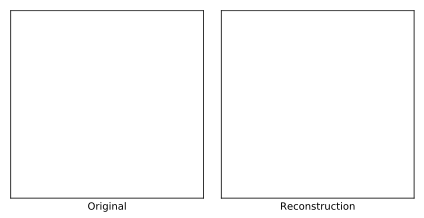

In [218]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(6, 3),
                               subplot_kw=dict(xticks=[], 
                                               yticks=[]))
fig.tight_layout()

x_pad, y_pad = 10, 10
    
x_pad //= 2
y_pad //= 2

(x_min_1, 
 x_max_1,
 y_min_1,
 y_max_1) = get_bounds(data=sketch, factor=.2)

(x_min_2, 
 x_max_2, 
 y_min_2, 
 y_max_2) = get_bounds(data=sketch_reconstructed, factor=.2)

x_min = np.minimum(x_min_1, x_min_2)
y_min = np.minimum(y_min_1, y_min_2)

x_max = np.maximum(x_max_1, x_max_2)
y_max = np.maximum(y_max_1, y_max_2)

ax1.set_xlim(x_min-x_pad, x_max+x_pad)
ax1.set_ylim(y_max+y_pad, y_min-y_pad)

ax1.set_xlabel('Original')

ax2.set_xlim(x_min-x_pad, x_max+x_pad)
ax2.set_ylim(y_max+y_pad, y_min-y_pad)

ax2.set_xlabel('Reconstruction')

In [219]:
def animate(i):

    original = SketchPath(sketch[:i+1])
    reconstructed = SketchPath(sketch_reconstructed[:i+1])

    patch1 = ax1.add_patch(patches.PathPatch(original,
                                             facecolor='none'))

    patch2 = ax2.add_patch(patches.PathPatch(reconstructed, 
                                             facecolor='none'))
    
    return patch1, patch2

In [220]:
frames = np.maximum(sketch.shape[0], 
                    sketch_reconstructed.shape[0])
frames

249

In [221]:
FuncAnimation(fig,
              animate,
              frames=frames-1, 
              interval=15,
              repeat_delay=1000*3, 
              blit=True)

Unfortunately, the strokes that make up a sketch have been normalized with the [Ramer–Douglas–Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm), which is a simple stroke simplification process. This means the strokes aren't quite the same as the that which the human originally used to construct the sketch. Moreover, the timing of each stroke are also important to understanding patterns in how humans draw quick sketches. While timestamp data is provided in the full QuickDraw dataset, they are not preserved in the modified version of the dataset used by SketchRNN.